# Handling 3D Inputs with PICASO

Many GCM groups have their files stored as `netCDF` files. Therefore, you may already be used to `xarray` format. If that is the case you will be able to directly input your xarray formatted data to `PICASO` to get out post-processed spectra. If not though, this tutorial will walk you through how to structure your data in xarray format. 

What you will learn: 

1. How to convert traditional numpy arrays to `xarray` formatted data, which is common for 3D GCM output
2. How to regrid using `xarray` and `xesmf`'s `regridder`
3. How to use `PICASO` built in function (which use #2)


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os

from picaso import justdoit as jdi

Two new packages you will need, that are not required components of other models: xesmf and xarray. You can read more about the installing these packages here: 

[Install XESFM](https://xesmf.readthedocs.io/en/latest/installation.html)
- will only be needed if you want to use their really handy regridding tools 

[Install xarray](http://xarray.pydata.org/en/stable/getting-started-guide/installing.html)
- needed for all `PICASO` 3d operations

In [2]:
import xesmf as xe
import xarray as xr

We will begin with an example file from the MIT GCM group (courtesy of Tiffany Kataria). 

In [3]:
gcm_out =  jdi.HJ_pt_3d()

We are going to go through the motions of converting basic `numpy` arrays to `xarray` format. **If you already understand xarrays you may skip to** the [`picaso` section](#regrid-3d-gcm-with-picaso)

In [4]:
gcm_out.keys()

dict_keys(['pressure', 'temperature', 'kzz', 'latitude', 'longitude'])

In this example, pressure, temperature, and kzz are all on a coordinate system that is : 

n_longitude (128) x n_latitude (64) x n_pressure (53)


In [5]:
gcm_out['temperature'].shape, len(gcm_out['longitude']), len(gcm_out['latitude'])

((128, 64, 53), 128, 64)

## `xarray` tutorial: Convert `numpy` arrays to  `xarray` DataSet

The comments with `required` next to them indicate that they are required for `picaso` to create a spectrum

In [6]:
# create data
data = gcm_out['temperature']

# create coords
lon = gcm_out['longitude']
lat = gcm_out['latitude']
pres = gcm_out['pressure'][0,0,:]

# put data into a dataset
ds = xr.Dataset(
    data_vars=dict(
        temperature=(["x", "y","z"], data,{'units': 'Kelvin'})#, required
        #kzz = (["x", "y","z"], gcm_out['kzz'])#could add other data components if wanted
    ),
    coords=dict(
        lon=(["x"], lon,{'units': 'degrees'}),#required
        lat=(["y"], lat,{'units': 'degrees'}),#required
        pressure=(["z"], pres,{'units': 'bar'})#required*
    ),
    attrs=dict(description="coords with vectors"),
)

### Variable Pressure Grid

In some cases, the pressure grid is not fixed and instead varies with latitude longitude. If this is the case you can add the pressure, latitude, and longitude as matrices, not vectors. 

In [7]:
# create coords
lon3d,lat3d, pres3d = np.meshgrid(gcm_out['longitude'],gcm_out['latitude'],
                                    gcm_out['pressure'][0,0,:], indexing='ij')

# create data
data = gcm_out['temperature']

# put data into a dataset
ds_variable_pressure = xr.Dataset(
    data_vars=dict(
        temperature=(["x","y",'z'], data,{'units': 'Kelvin'})
    ),
    coords=dict(
        lon=(["x","y",'z'], lon3d,{'units': 'degrees'}),
        lat=(["x","y",'z'], lat3d,{'units': 'degrees'}),
        pressure=(["x","y",'z'], pres3d,{'units': 'bar'}),
    ),
    attrs=dict(description="coords with matrices"),
)

##  `xarray` tutorial: Easy plotting

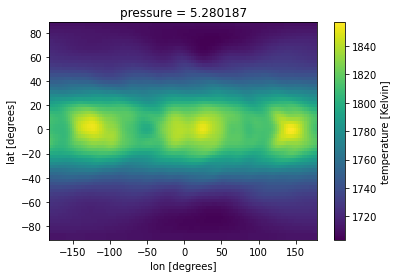

In [8]:
ds['temperature'].isel(z=10).plot(x='lon',y='lat')

## `xesfm` tutorial: Step-by-step regrid 3D GCM 

The biggest complication with moving to 3D is making sure that the latitude/longitude grids of some users GCM and `picaso` line up properly. `picaso` computes a flux integration on specific `gauss` and `tchebychev` angles. **Meaning, your GCM input will need to be regridded to fit our angles.** Luckily, as you will see below, it is very easy to do this!

First, we will show you how this is done using `xesfm`, then we will introduce the `PICASO` function that leverages these same techniques. 

### Step 1) Get latitude/longitude grid used by `picaso`

**G**auss angles are essentially equivalent to lon**G**itudes 

**T**chebychev angles are essentially equivalent to la**T**itudes. 

In [9]:
n_gauss_angles =10
n_chebychev_angles=10

gangle, gweight, tangle, tweight = jdi.get_angles_3d(n_gauss_angles, n_chebychev_angles)
ubar0, ubar1, cos_theta, latitude, longitude = jdi.compute_disco(n_gauss_angles, n_chebychev_angles, gangle, tangle, phase_angle=0)


### Step 2) Create the `xesfm` regridder 

In [10]:
ds_out = xr.Dataset({'lon': (['x'], longitude*180/np.pi),
                     'lat': (['y'], latitude*180/np.pi),
                    }
                   )

regridder = xe.Regridder(ds, ds_out, 'bilinear')
ds_out = regridder(ds,keep_attrs=True)

All done!

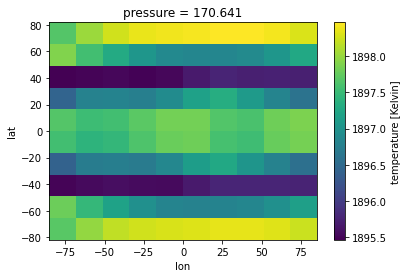

In [11]:
ds_out['temperature'].isel(z=0).plot(x='lon', y ='lat')

## Regrid 3D GCM with PICASO

The above code is all the PICASO built in function does -- in addition to completing some checks to make sure that your model run is on the same grid as what you are wanting PICASO run. 

In [12]:
ds =  jdi.HJ_pt_3d(as_xarray=True)

### Option 1

For completeness, first here is the function `picaso` uses internally. You might use this if you want to manipulate results before supplying `picaso` with your final input.

verbose=True;Only one data variable included. Make sure to add in chemical abundances before trying to run spectra.


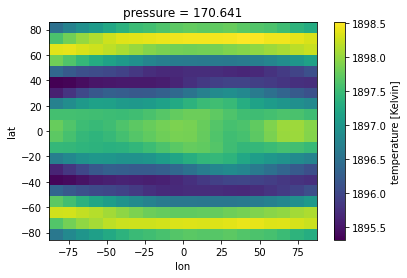

In [13]:
#regrid yourself
out_ds = jdi.regrid_xarray(ds, num_gangle=20, 
                               num_tangle=20, phase_angle=0) 
#then supply to picaso
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_gangle=20, num_tangle=20)

#here, regrid is false because you have already done it yourself
case_3d.atmosphere_3d(out_ds,regrid=False,plot=True,verbose=True)

### Easiest Option 2

Use the regular `PICASO` workflow to regrid your 3d input

verbose=True;regrid=True; Regridding 3D output to ngangle=20, ntangle=20, with phase=0.
verbose=True;Only one data variable included. Make sure to add in chemical abundances before trying to run spectra.


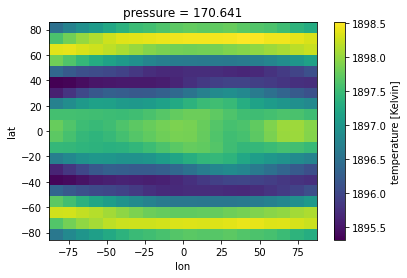

In [14]:
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_gangle=20, num_tangle=20)
#regrid is True as you will do it within the function
case_3d.atmosphere_3d(ds,regrid=True,plot=True,verbose=True)

We have solved regridding our temperature-pressure profile. However, PICASO has notified us of another step we must take before running a spectrum: *verbose=True;Only one data variable included. Make sure to add in chemical abundances before trying to run spectra.* 

In the next notebook you will see how to add chemistry and/or clouds to your 3D input. 